In [1]:
cd /g/data/jk72/deg581/apom/ana/notebooks

/g/data/jk72/deg581/apom/ana/notebooks


In [2]:
# load modules
## Data processing and DA modules
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
import matplotlib.ticker as mticker

## Dealing with big data and netcdf
import xarray as xr
from netCDF4 import Dataset
## ROMS packages
from xgcm import Grid
## color maps
import cmaps
import cmocean
## mapping packages
import cartopy.crs as ccrs
import cartopy.feature as cfeature
## System tools and python configuration
import os
import glob
# import repackage
# repackage.add('../../')
# repackage.add('../')

In [3]:
def _distq(lon1, lat1, lon2, lat2):
    """
    Compute the geodesic distance between lat/lon points. This code is
    taken from the dist.f routine and the Matlab version distg.m passed
    around WHOI and APL. This was stripped down to use the WGS84 ellipsoid.

    Parameters
    ----------
    lon1 : array_like or scalar
        Input array of source longitude(s)
    lat1 : array_like or scalar
        Input array of source latitude(s)
    lon2 : array_like or scalar
        Input array of destination longitude(s)
    lat2 : array_like or scalar
        Input array of destination latitude(s)

    Returns
    -------
    distance : array or scalar of distance in meters
    angle: array or scalar of angle in radians

    """
    lon1 = np.asanyarray(np.radians(lon1))
    lat1 = np.asanyarray(np.radians(lat1))
    lon2 = np.asanyarray(np.radians(lon2))
    lat2 = np.asanyarray(np.radians(lat2))

    # # If one of the points is a singleton and the other is an
    # array, make them the same size
    if lon1.size == 1 and lon2.size > 1:
        lon1 = lon1.repeat(lon2.size)
        lat1 = lat1.repeat(lat2.size)
    if lon2.size == 1 and lon1.size > 1:
        lon2 = lon2.repeat(lon1.size)
        lat2 = lat2.repeat(lat1.size)

    # Set the WGS84 parameters
    A = 6378137.
    E = 0.081819191
    B = np.sqrt(A * A - (A * E)**2)
    EPS = E * E / (1.0 - E * E)

    # Move any latitudes off of the equator
    lat1[lat1 == 0] = np.finfo(float).eps
    lat2[lat2 == 0] = -np.finfo(float).eps

    # COMPUTE THE RADIUS OF CURVATURE IN THE PRIME VERTICAL FOR EACH POINT
    xnu1 = A / np.sqrt(1.0 - (E * np.sin(lat1))**2)
    xnu2 = A / np.sqrt(1.0 - (E * np.sin(lat2))**2)

    TPSI2 = (1.0 - E * E) * np.tan(lat2) + E * E * xnu1 * np.sin(lat1) / \
        (xnu2 * np.cos(lat2))
    PSI2 = np.arctan(TPSI2)

    DPHI2 = lat2 - PSI2
    DLAM = (lon2 - lon1) + np.finfo(float).eps
    CTA12 = np.sin(DLAM) / (np.cos(lat1) * TPSI2 - np.sin(lat1) * np.cos(DLAM))
    A12 = np.arctan(CTA12)
    CTA21P = np.sin(DLAM) / (np.sin(PSI2) * np.cos(DLAM) -
                            np.cos(PSI2) * np.tan(lat1))
    A21P = np.arctan(CTA21P)

    # C    GET THE QUADRANT RIGHT
    DLAM2 = (np.abs(DLAM) < np.pi).astype(int) * DLAM + \
        (DLAM >= np.pi).astype(int) * (-2 * np.pi + DLAM) + \
        (DLAM <= -np.pi).astype(int) * (2 * np.pi + DLAM)
    A12 = A12 + (A12 < -np.pi).astype(int) * 2 * np.pi - \
        (A12 >= np.pi).astype(int) * 2 * np.pi
    A12 = A12 + np.pi * np.sign(-A12) * \
        (np.sign(A12).astype(int) != np.sign(DLAM2))
    A21P = A21P + (A21P < -np.pi).astype(int) * 2 * np.pi - \
        (A21P >= np.pi).astype(int) * 2 * np.pi
    A21P = A21P + np.pi * np.sign(-A21P) * \
        (np.sign(A21P).astype(int) != np.sign(-DLAM2))

    SSIG = np.sin(DLAM) * np.cos(PSI2) / np.sin(A12)

    dd1 = np.array([np.cos(lon1) * np.cos(lat1),
                    np.sin(lon1) * np.cos(lat1), np.sin(lat1)])
    dd2 = np.array([np.cos(lon2) * np.cos(lat2),
                    np.sin(lon2) * np.cos(lat2), np.sin(lat2)])
    dd2 = np.sum((dd2 - dd1)**2, axis=0)
    bigbrnch = (dd2 > 2).astype(int)

    SIG = np.arcsin(SSIG) * (bigbrnch == 0).astype(int) + \
        (np.pi - np.arcsin(SSIG)) * bigbrnch

    SSIGC = -np.sin(DLAM) * np.cos(lat1) / np.sin(A21P)
    SIGC = np.arcsin(SSIGC)
    A21 = A21P - DPHI2 * np.sin(A21P) * np.tan(SIG / 2.0)

    # C   COMPUTE RANGE
    G2 = EPS * (np.sin(lat1))**2
    G = np.sqrt(G2)
    H2 = EPS * (np.cos(lat1) * np.cos(A12))**2
    H = np.sqrt(H2)
    SIG2 = SIG * SIG
    TERM1 = -H2 * (1.0 - H2) / 6.0
    TERM2 = G * H * (1.0 - 2.0 * H2) / 8.0
    TERM3 = (H2 * (4.0 - 7.0 * H2) - 3.0 * G2 * (1.0 - 7.0 * H2)) / 120.0
    TERM4 = -G * H / 48.0
    rng = xnu1 * SIG * (1.0 + SIG2 * (TERM1 + SIG * TERM2 + SIG2 * TERM3 +
                                    SIG2 * SIG * TERM4))

    return rng, A12


def earth_angle(lon1, lat1, lon2, lat2):
    """
    Compute the angle between lat/lon points. NOTE: The bearing angle
    is computed, but then converted to geometric (counter-clockwise)
    angle to be returned.

    Parameters
    ----------
    lon1 : array_like or scalar
        Input array of source longitude(s)
    lat1 : array_like or scalar
        Input array of source latitude(s)
    lon2 : array_like or scalar
        Input array of destination longitude(s)
    lat2 : array_like or scalar
        Input array of destination latitude(s)

    Returns
    -------
    angle : array or scalar of bearing in radians

    """
    _, angle = _distq(lon1, lat1, lon2, lat2)
    # return (np.pi / 2.0 - angle)
    return (angle)



In [4]:

def inpolygon(xq, yq, xv, yv):
    from matplotlib import path
    shape = xq.shape
    xq = xq.reshape(-1)
    yq = yq.reshape(-1)
    xv = xv.reshape(-1)
    yv = yv.reshape(-1)
    q = [(xq[i], yq[i]) for i in range(xq.shape[0])]
    p = path.Path([(xv[i], yv[i]) for i in range(xv.shape[0])])
    return p.contains_points(q).reshape(shape)

# map u,v to rho points
def ROMSmetricsAndGrid(ds):
    ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
        'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
        'Z':{'center':'s_rho', 'outer':'s_w'}}

    grid = Grid(ds, coords=coords, periodic=[])

    print('making pm/pn metrics')
    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)
    print('making dx/dy')
    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi

    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi

#     ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
#     ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
#     ds['dz_u'] = grid.interp(ds.dz, 'X')
#     ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
#     ds['dz_v'] = grid.interp(ds.dz, 'Y')
#     ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy

    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        # ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    }
    grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])

    return ds,grid



def add_zeros_to_4(date):
    if date<10:
        to_add = '000'
    elif date>9 & date<100:
        to_add = '00'
    elif date>99 & date < 1000:
        to_add = '0'
    else: 
        to_add = ''
    return to_add

def generateFileList(FilePath,prefix,datelist):
    filelist=[FilePath+prefix+add_zeros_to_4(datelist[0])+str(datelist[0])+'.nc']
    for dates in datelist[1:]:
        filenameToAppend=FilePath+prefix+add_zeros_to_4(dates)+str(dates)+'.nc'
        filelist.append(filenameToAppend)
    return filelist

In [5]:
winter_period_doy=slice(49,62)
summer_period_doy=slice(12,25)


### load data sets

In [6]:
grd = xr.open_dataset('/g/data/jk72/deg581/apom/frc/amery_v2km_v13_grd.nc')


### load density export datasets

In [7]:
outflow_MKPA = xr.open_dataarray('../data/proc/MKPA_outflow_pos.nc')
outflow_AIS05 = xr.open_dataarray('../data/proc/AIS05_outflow_pos.nc')
outflow_AIS2 = xr.open_dataarray('../data/proc/AIS2_outflow_pos.nc')
outflow_CTRL = xr.open_dataarray('../data/proc/CTRL_outflow_pos.nc')


In [8]:
# grab outflow > 27.8 and ?27.9
density_mask_278 = np.tile(outflow_CTRL.dens_class>27.8,(len(outflow_CTRL.dayofyear),1))
density_mask_2788 = np.tile(outflow_CTRL.dens_class>27.88,(len(outflow_CTRL.dayofyear),1))


integrated_outflow_pos_CTRL = outflow_CTRL.sum(dim={'dC','s_rho'})
dens_integrated_outflow_pos_278_CTRL = integrated_outflow_pos_CTRL.copy()
dens_integrated_outflow_pos_2788_CTRL = integrated_outflow_pos_CTRL.copy()
dens_outflow_278_ts_CTRL = (dens_integrated_outflow_pos_278_CTRL*density_mask_278).sum(dim='dens_class')
dens_outflow_2788_ts_CTRL = (dens_integrated_outflow_pos_2788_CTRL*density_mask_2788).sum(dim='dens_class')

integrated_outflow_pos_MKPA = outflow_MKPA.sum(dim={'dC','s_rho'})
dens_integrated_outflow_pos_278_MKPA = integrated_outflow_pos_MKPA.copy()
dens_integrated_outflow_pos_2788_MKPA = integrated_outflow_pos_MKPA.copy()
dens_outflow_278_ts_MKPA = (dens_integrated_outflow_pos_278_MKPA*density_mask_278).sum(dim='dens_class')
dens_outflow_2788_ts_MKPA = (dens_integrated_outflow_pos_2788_MKPA*density_mask_2788).sum(dim='dens_class')

integrated_outflow_pos_AIS05 = outflow_AIS05.sum(dim={'dC','s_rho'})
dens_integrated_outflow_pos_278_AIS05 = integrated_outflow_pos_AIS05.copy()
dens_integrated_outflow_pos_2788_AIS05 = integrated_outflow_pos_AIS05.copy()
dens_outflow_278_ts_AIS05 = (dens_integrated_outflow_pos_278_AIS05*density_mask_278).sum(dim='dens_class')
dens_outflow_2788_ts_AIS05 = (dens_integrated_outflow_pos_2788_AIS05*density_mask_2788).sum(dim='dens_class')


integrated_outflow_pos_AIS2 = outflow_AIS2.sum(dim={'dC','s_rho'})
dens_integrated_outflow_pos_278_AIS2 = integrated_outflow_pos_AIS2.copy()
dens_integrated_outflow_pos_2788_AIS2 = integrated_outflow_pos_AIS2.copy()
dens_outflow_278_ts_AIS2 = (dens_integrated_outflow_pos_278_AIS2*density_mask_278).sum(dim='dens_class')
dens_outflow_2788_ts_AIS2 = (dens_integrated_outflow_pos_2788_AIS2*density_mask_2788).sum(dim='dens_class')



Text(0.5, 0, 'Day of year')

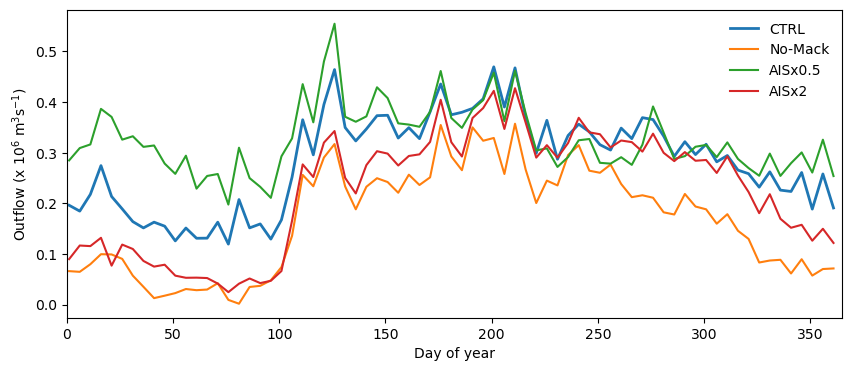

In [9]:
fig = plt.figure(figsize=(10,4))

gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.2, hspace=0.2)
plt.cla()
plt.clf()

ax=fig.add_subplot(gs[0,0])
ax.plot(outflow_CTRL.dayofyear,dens_outflow_278_ts_CTRL/1e6,color='C0',label='CTRL',linewidth=2)
# ax.plot(outflow_CTRL.dayofyear,dens_outflow_2788_ts_CTRL/1e6,color='C0',label='>1027.88')
ax.plot(outflow_CTRL.dayofyear,dens_outflow_278_ts_MKPA/1e6,color='C1',label='No-Mack')
# ax.plot(outflow_CTRL.dayofyear,dens_outflow_2788_ts_MKPA/1e6,color='C1',label='No-Mack')
ax.plot(outflow_CTRL.dayofyear,dens_outflow_278_ts_AIS05/1e6,color='C2',label='AISx0.5')
# ax.plot(outflow_CTRL.dayofyear,dens_outflow_2788_ts_AIS05/1e6,color='C2',label='AISx0.5')
ax.plot(outflow_CTRL.dayofyear,dens_outflow_278_ts_AIS2/1e6,color='C3',label='AISx2')
# ax.plot(outflow_CTRL.dayofyear,dens_outflow_2788_ts_AIS2/1e6,color='C3',label='AISx2')

ax.set_xlim((0,365))
ax.legend(frameon=False)
ax.set_ylabel('Outflow (x 10$^6$ m$^3$s$^{-1}$)')
ax.set_xlabel('Day of year')

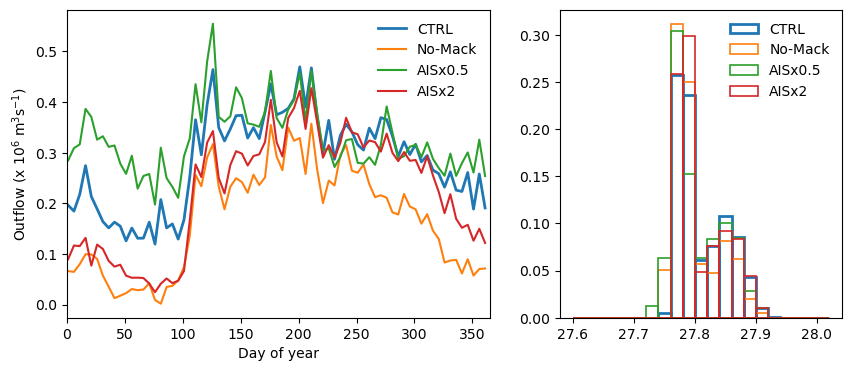

In [10]:
fig = plt.figure(figsize=(10,4))

gs = gridspec.GridSpec(nrows=1,ncols=2,wspace=0.2, hspace=0.2,width_ratios=[0.6,0.4])
plt.cla()
plt.clf()

ax=fig.add_subplot(gs[0,0])
ax.plot(outflow_CTRL.dayofyear,dens_outflow_278_ts_CTRL/1e6,color='C0',label='CTRL',linewidth=2)
# ax.plot(outflow_CTRL.dayofyear,dens_outflow_2788_ts_CTRL/1e6,color='C0',label='>1027.88')
ax.plot(outflow_CTRL.dayofyear,dens_outflow_278_ts_MKPA/1e6,color='C1',label='No-Mack')
# ax.plot(outflow_CTRL.dayofyear,dens_outflow_2788_ts_MKPA/1e6,color='C1',label='No-Mack')
ax.plot(outflow_CTRL.dayofyear,dens_outflow_278_ts_AIS05/1e6,color='C2',label='AISx0.5')
# ax.plot(outflow_CTRL.dayofyear,dens_outflow_2788_ts_AIS05/1e6,color='C2',label='AISx0.5')
ax.plot(outflow_CTRL.dayofyear,dens_outflow_278_ts_AIS2/1e6,color='C3',label='AISx2')
# ax.plot(outflow_CTRL.dayofyear,dens_outflow_2788_ts_AIS2/1e6,color='C3',label='AISx2')

ax.set_xlim((0,365))
ax.legend(frameon=False)
ax.set_ylabel('Outflow (x 10$^6$ m$^3$s$^{-1}$)')
ax.set_xlabel('Day of year')

ax=fig.add_subplot(gs[0,1])

ax.hist(outflow_CTRL.dens_class,weights=outflow_CTRL.isel(dayofyear=winter_period_doy).sum(dim={'dC','s_rho'}).mean(dim='dayofyear')/1e6,bins=outflow_CTRL.dens_class,edgecolor='C0', stacked=True, fill=False, label='CTRL',linewidth=2)
ax.hist(outflow_CTRL.dens_class,weights=outflow_MKPA.isel(dayofyear=winter_period_doy).sum(dim={'dC','s_rho'}).mean(dim='dayofyear')/1e6,bins=outflow_MKPA.dens_class,edgecolor='C1', stacked=True, fill=False, label='No-Mack',linewidth=1.2)
ax.hist(outflow_CTRL.dens_class,weights=outflow_AIS05.isel(dayofyear=winter_period_doy).sum(dim={'dC','s_rho'}).mean(dim='dayofyear')/1e6,bins=outflow_AIS05.dens_class,edgecolor='C2', stacked=True, fill=False, label='AISx0.5',linewidth=1.2)
ax.hist(outflow_CTRL.dens_class,weights=outflow_AIS2.isel(dayofyear=winter_period_doy).sum(dim={'dC','s_rho'}).mean(dim='dayofyear')/1e6,bins=outflow_AIS2.dens_class,edgecolor='C3', stacked=True, fill=False, label='AISx2',linewidth=1.2)
# plt.hist(density_classes,weights=np.nanmean(np.nansum(np.nansum(outflow_pos[summer_period],axis=3),axis=2),axis=0),bins=density_classes,color='C1', stacked=True, fill=False)
ax.legend(frameon=False)


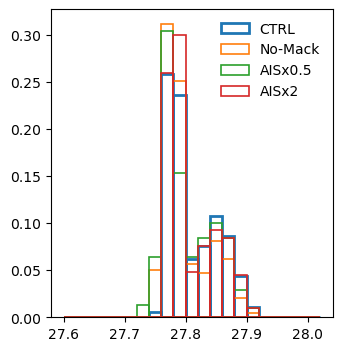

In [11]:
fig = plt.figure(figsize=(10,4))

gs = gridspec.GridSpec(nrows=1,ncols=2,wspace=0.2, hspace=0.2,width_ratios=[0.6,0.4])
plt.cla()
plt.clf()

ax=fig.add_subplot(gs[0,1])

ax.hist(outflow_CTRL.dens_class,weights=outflow_CTRL.isel(dayofyear=winter_period_doy).sum(dim={'dC','s_rho'}).mean(dim='dayofyear')/1e6,bins=outflow_CTRL.dens_class,edgecolor='C0', stacked=True, fill=False, label='CTRL',linewidth=2)
ax.hist(outflow_CTRL.dens_class,weights=outflow_MKPA.isel(dayofyear=winter_period_doy).sum(dim={'dC','s_rho'}).mean(dim='dayofyear')/1e6,bins=outflow_MKPA.dens_class,edgecolor='C1', stacked=True, fill=False, label='No-Mack',linewidth=1.2)
ax.hist(outflow_CTRL.dens_class,weights=outflow_AIS05.isel(dayofyear=winter_period_doy).sum(dim={'dC','s_rho'}).mean(dim='dayofyear')/1e6,bins=outflow_AIS05.dens_class,edgecolor='C2', stacked=True, fill=False, label='AISx0.5',linewidth=1.2)
ax.hist(outflow_CTRL.dens_class,weights=outflow_AIS2.isel(dayofyear=winter_period_doy).sum(dim={'dC','s_rho'}).mean(dim='dayofyear')/1e6,bins=outflow_AIS2.dens_class,edgecolor='C3', stacked=True, fill=False, label='AISx2',linewidth=1.2)
# plt.hist(density_classes,weights=np.nanmean(np.nansum(np.nansum(outflow_pos[summer_period],axis=3),axis=2),axis=0),bins=density_classes,color='C1', stacked=True, fill=False)
ax.legend(frameon=False)

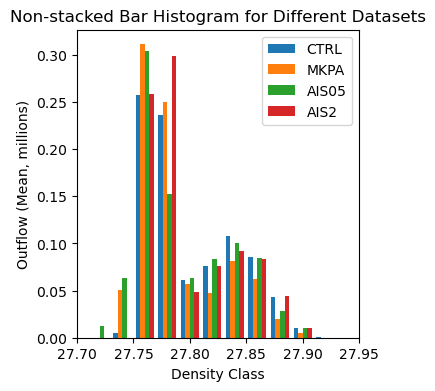

In [12]:
# Assuming bin_centers is an xarray.DataArray
bin_centers = outflow_CTRL.dens_class

# Calculate bin edges, ensuring conversion to numpy arrays
bin_edges = np.zeros(len(bin_centers) + 1)
bin_edges[1:-1] = (bin_centers[:-1].values + bin_centers[1:].values) / 2  # Midpoints
bin_edges[0] = bin_centers[0].values - (bin_centers[1].values - bin_centers[0].values) / 2  # Lower boundary
bin_edges[-1] = bin_centers[-1].values + (bin_centers[-1].values - bin_centers[-2].values) / 2  # Upper boundary

# Bar width based on calculated edges
bar_width = (bin_edges[1] - bin_edges[0]) / 5  # Adjust width and spacing


data1 = outflow_CTRL.isel(dayofyear=winter_period_doy).sum(dim={'dC', 's_rho'}).mean(dim='dayofyear') / 1e6
data2 = outflow_MKPA.isel(dayofyear=winter_period_doy).sum(dim={'dC', 's_rho'}).mean(dim='dayofyear') / 1e6
data3 = outflow_AIS05.isel(dayofyear=winter_period_doy).sum(dim={'dC', 's_rho'}).mean(dim='dayofyear') / 1e6
data4 = outflow_AIS2.isel(dayofyear=winter_period_doy).sum(dim={'dC', 's_rho'}).mean(dim='dayofyear') / 1e6

fig = plt.figure(figsize=(10,4))

gs = gridspec.GridSpec(nrows=1,ncols=2,wspace=0.2, hspace=0.2,width_ratios=[0.6,0.4])
plt.cla()
plt.clf()

ax=fig.add_subplot(gs[0,1])


# Create the histogram bars with offsets
plt.bar(bin_centers.values - 1.5 * bar_width, data1.values, width=bar_width, label='CTRL')
plt.bar(bin_centers.values - 0.5 * bar_width, data2.values, width=bar_width, label='MKPA')
plt.bar(bin_centers.values + 0.5 * bar_width, data3.values, width=bar_width, label='AIS05')
plt.bar(bin_centers.values + 1.5 * bar_width, data4.values, width=bar_width, label='AIS2')


# Add labels and legend
ax.set_xlim((27.7,27.95))
ax.set_xlabel('Density Class')
ax.set_ylabel('Outflow (Mean, millions)')
ax.set_title('Non-stacked Bar Histogram for Different Datasets')
ax.legend()

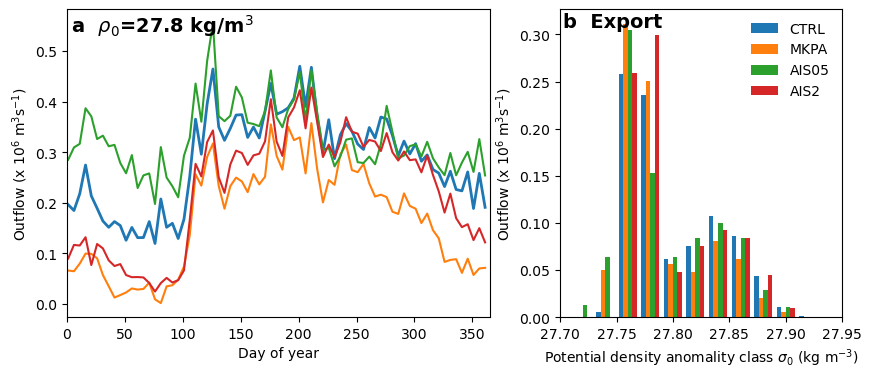

In [13]:
fig = plt.figure(figsize=(10,4))

gs = gridspec.GridSpec(nrows=1,ncols=2,wspace=0.2, hspace=0.2,width_ratios=[0.6,0.4])
plt.cla()
plt.clf()

ax=fig.add_subplot(gs[0,0])
ax.plot(outflow_CTRL.dayofyear,dens_outflow_278_ts_CTRL/1e6,color='C0',label='CTRL',linewidth=2)
# ax.plot(outflow_CTRL.dayofyear,dens_outflow_2788_ts_CTRL/1e6,color='C0',label='>1027.88')
ax.plot(outflow_CTRL.dayofyear,dens_outflow_278_ts_MKPA/1e6,color='C1',label='No-Mack')
# ax.plot(outflow_CTRL.dayofyear,dens_outflow_2788_ts_MKPA/1e6,color='C1',label='No-Mack')
ax.plot(outflow_CTRL.dayofyear,dens_outflow_278_ts_AIS05/1e6,color='C2',label='AISx0.5')
# ax.plot(outflow_CTRL.dayofyear,dens_outflow_2788_ts_AIS05/1e6,color='C2',label='AISx0.5')
ax.plot(outflow_CTRL.dayofyear,dens_outflow_278_ts_AIS2/1e6,color='C3',label='AISx2')
# ax.plot(outflow_CTRL.dayofyear,dens_outflow_2788_ts_AIS2/1e6,color='C3',label='AISx2')

ax.set_xlim((0,365))
# ax.legend(frameon=False)
ax.set_ylabel('Outflow (x 10$^6$ m$^3$s$^{-1}$)')
ax.set_xlabel('Day of year')
ax.text(0.01, 0.99, r'a  $\rho_0$=27.8 kg/m$^3$', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')

ax=fig.add_subplot(gs[0,1])


# Assuming bin_centers is an xarray.DataArray
bin_centers = outflow_CTRL.dens_class

# Calculate bin edges, ensuring conversion to numpy arrays
bin_edges = np.zeros(len(bin_centers) + 1)
bin_edges[1:-1] = (bin_centers[:-1].values + bin_centers[1:].values) / 2  # Midpoints
bin_edges[0] = bin_centers[0].values - (bin_centers[1].values - bin_centers[0].values) / 2  # Lower boundary
bin_edges[-1] = bin_centers[-1].values + (bin_centers[-1].values - bin_centers[-2].values) / 2  # Upper boundary

# Bar width based on calculated edges
bar_width = (bin_edges[1] - bin_edges[0]) / 5  # Adjust width and spacing


data1 = outflow_CTRL.isel(dayofyear=winter_period_doy).sum(dim={'dC', 's_rho'}).mean(dim='dayofyear') / 1e6
data2 = outflow_MKPA.isel(dayofyear=winter_period_doy).sum(dim={'dC', 's_rho'}).mean(dim='dayofyear') / 1e6
data3 = outflow_AIS05.isel(dayofyear=winter_period_doy).sum(dim={'dC', 's_rho'}).mean(dim='dayofyear') / 1e6
data4 = outflow_AIS2.isel(dayofyear=winter_period_doy).sum(dim={'dC', 's_rho'}).mean(dim='dayofyear') / 1e6


# Create the histogram bars with offsets
plt.bar(bin_centers.values - 1.5 * bar_width, data1.values, width=bar_width, label='CTRL')
plt.bar(bin_centers.values - 0.5 * bar_width, data2.values, width=bar_width, label='MKPA')
plt.bar(bin_centers.values + 0.5 * bar_width, data3.values, width=bar_width, label='AIS05')
plt.bar(bin_centers.values + 1.5 * bar_width, data4.values, width=bar_width, label='AIS2')


# Add labels and legend
ax.set_xlim((27.7,27.95))
ax.set_ylabel('Outflow (x 10$^6$ m$^3$s$^{-1}$)')
ax.set_xlabel('Potential density anomality class $\sigma_0$ (kg m$^{-3}$)')
ax.text(0.01, 0.99, 'b  Export', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.legend(frameon=False)


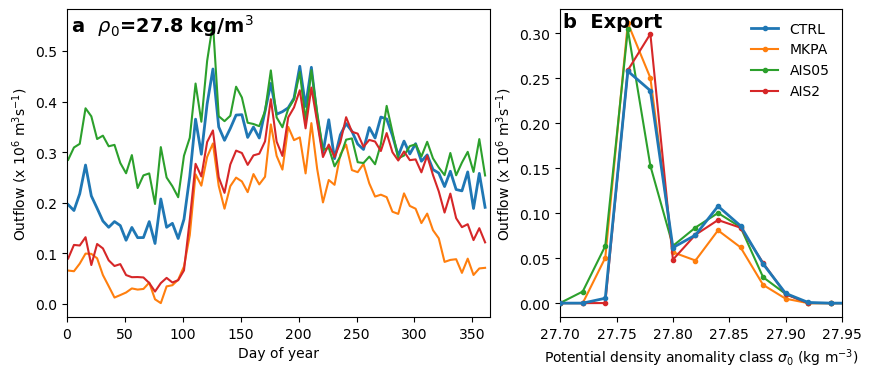

In [14]:
fig = plt.figure(figsize=(10,4))

gs = gridspec.GridSpec(nrows=1,ncols=2,wspace=0.2, hspace=0.2,width_ratios=[0.6,0.4])
plt.cla()
plt.clf()

ax=fig.add_subplot(gs[0,0])
ax.plot(outflow_CTRL.dayofyear,dens_outflow_278_ts_CTRL/1e6,color='C0',label='CTRL',linewidth=2)
# ax.plot(outflow_CTRL.dayofyear,dens_outflow_2788_ts_CTRL/1e6,color='C0',label='>1027.88')
ax.plot(outflow_CTRL.dayofyear,dens_outflow_278_ts_MKPA/1e6,color='C1',label='No-Mack')
# ax.plot(outflow_CTRL.dayofyear,dens_outflow_2788_ts_MKPA/1e6,color='C1',label='No-Mack')
ax.plot(outflow_CTRL.dayofyear,dens_outflow_278_ts_AIS05/1e6,color='C2',label='AISx0.5')
# ax.plot(outflow_CTRL.dayofyear,dens_outflow_2788_ts_AIS05/1e6,color='C2',label='AISx0.5')
ax.plot(outflow_CTRL.dayofyear,dens_outflow_278_ts_AIS2/1e6,color='C3',label='AISx2')
# ax.plot(outflow_CTRL.dayofyear,dens_outflow_2788_ts_AIS2/1e6,color='C3',label='AISx2')

ax.set_xlim((0,365))
# ax.legend(frameon=False)
ax.set_ylabel('Outflow (x 10$^6$ m$^3$s$^{-1}$)')
ax.set_xlabel('Day of year')
ax.text(0.01, 0.99, r'a  $\rho_0$=27.8 kg/m$^3$', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')

ax=fig.add_subplot(gs[0,1])


data1 = outflow_CTRL.isel(dayofyear=winter_period_doy).sum(dim={'dC', 's_rho'}).mean(dim='dayofyear') / 1e6
data2 = outflow_MKPA.isel(dayofyear=winter_period_doy).sum(dim={'dC', 's_rho'}).mean(dim='dayofyear') / 1e6
data3 = outflow_AIS05.isel(dayofyear=winter_period_doy).sum(dim={'dC', 's_rho'}).mean(dim='dayofyear') / 1e6
data4 = outflow_AIS2.isel(dayofyear=winter_period_doy).sum(dim={'dC', 's_rho'}).mean(dim='dayofyear') / 1e6


# Create the histogram bars with offsets
ax.plot(outflow_CTRL.dens_class,data1,marker='.',label='CTRL',linewidth=2,zorder=10)
ax.plot(outflow_CTRL.dens_class,data2,marker='.',label='MKPA')
ax.plot(outflow_CTRL.dens_class,data3,marker='.',label='AIS05')
ax.plot(outflow_CTRL.dens_class,data4,marker='.',label='AIS2')


# Add labels and legend
ax.set_xlim((27.7,27.95))
ax.set_ylabel('Outflow (x 10$^6$ m$^3$s$^{-1}$)')
ax.set_xlabel('Potential density anomality class $\sigma_0$ (kg m$^{-3}$)')
ax.text(0.01, 0.99, 'b  Export', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.legend(frameon=False)


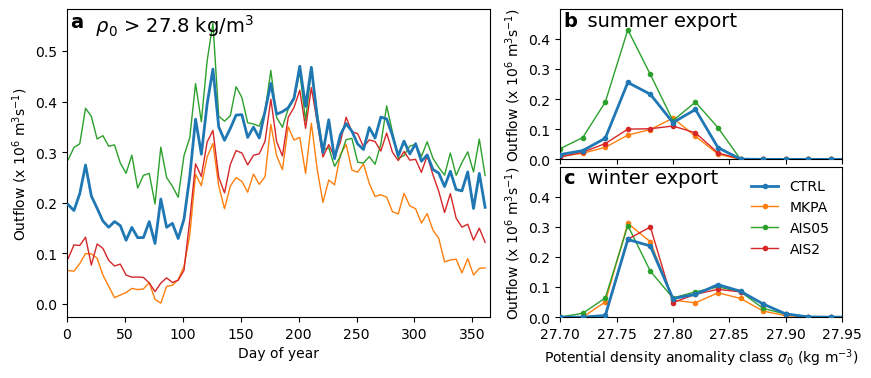

In [15]:
fig = plt.figure(figsize=(10,4))

gs = gridspec.GridSpec(nrows=2,ncols=2,wspace=0.2, hspace=0.05,width_ratios=[0.6,0.4])
plt.cla()
plt.clf()

ax=fig.add_subplot(gs[:,0])
ax.plot(outflow_CTRL.dayofyear,dens_outflow_278_ts_CTRL/1e6,color='C0',label='CTRL',linewidth=2,zorder=10)
# ax.plot(outflow_CTRL.dayofyear,dens_outflow_2788_ts_CTRL/1e6,color='C0',label='>1027.88')
ax.plot(outflow_CTRL.dayofyear,dens_outflow_278_ts_MKPA/1e6,color='C1',label='No-Mack',linewidth=1)
# ax.plot(outflow_CTRL.dayofyear,dens_outflow_2788_ts_MKPA/1e6,color='C1',label='No-Mack')
ax.plot(outflow_CTRL.dayofyear,dens_outflow_278_ts_AIS05/1e6,color='C2',label='AISx0.5',linewidth=1)
# ax.plot(outflow_CTRL.dayofyear,dens_outflow_2788_ts_AIS05/1e6,color='C2',label='AISx0.5')
ax.plot(outflow_CTRL.dayofyear,dens_outflow_278_ts_AIS2/1e6,color='C3',label='AISx2',linewidth=1)
# ax.plot(outflow_CTRL.dayofyear,dens_outflow_2788_ts_AIS2/1e6,color='C3',label='AISx2')

ax.set_xlim((0,365))
# ax.legend(frameon=False)
ax.set_ylabel('Outflow (x 10$^6$ m$^3$s$^{-1}$)')
ax.set_xlabel('Day of year')
ax.text(0.01, 0.99, r'a ', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.text(0.01, 0.99, r'    $\rho_0$ > 27.8 kg/m$^3$', transform=ax.transAxes,fontsize=14, va='top')

ax=fig.add_subplot(gs[0,1])


data1 = outflow_CTRL.isel(dayofyear=summer_period_doy).sum(dim={'dC', 's_rho'}).mean(dim='dayofyear') / 1e6
data2 = outflow_MKPA.isel(dayofyear=summer_period_doy).sum(dim={'dC', 's_rho'}).mean(dim='dayofyear') / 1e6
data3 = outflow_AIS05.isel(dayofyear=summer_period_doy).sum(dim={'dC', 's_rho'}).mean(dim='dayofyear') / 1e6
data4 = outflow_AIS2.isel(dayofyear=summer_period_doy).sum(dim={'dC', 's_rho'}).mean(dim='dayofyear') / 1e6


# Create the histogram bars with offsets
ax.plot(outflow_CTRL.dens_class,data1,marker='.',label='CTRL',linewidth=2,zorder=10)
ax.plot(outflow_CTRL.dens_class,data2,marker='.',label='MKPA',linewidth=1)
ax.plot(outflow_CTRL.dens_class,data3,marker='.',label='AIS05',linewidth=1)
ax.plot(outflow_CTRL.dens_class,data4,marker='.',label='AIS2',linewidth=1)


# Add labels and legend
ax.set_xlim((27.7,27.95))
ax.set_ylim((0,0.499))
ax.set_ylabel('Outflow (x 10$^6$ m$^3$s$^{-1}$)')
# ax.set_xlabel('Potential density anomality class $\sigma_0$ (kg m$^{-3}$)')
ax.set_xticklabels([])
ax.text(0.01, 0.99, 'b', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.text(0.01, 0.99, '    summer export', transform=ax.transAxes,fontsize=14, va='top')
# ax.legend(frameon=False)


ax=fig.add_subplot(gs[1,1])


data1 = outflow_CTRL.isel(dayofyear=winter_period_doy).sum(dim={'dC', 's_rho'}).mean(dim='dayofyear') / 1e6
data2 = outflow_MKPA.isel(dayofyear=winter_period_doy).sum(dim={'dC', 's_rho'}).mean(dim='dayofyear') / 1e6
data3 = outflow_AIS05.isel(dayofyear=winter_period_doy).sum(dim={'dC', 's_rho'}).mean(dim='dayofyear') / 1e6
data4 = outflow_AIS2.isel(dayofyear=winter_period_doy).sum(dim={'dC', 's_rho'}).mean(dim='dayofyear') / 1e6


# Create the histogram bars with offsets
ax.plot(outflow_CTRL.dens_class,data1,marker='.',label='CTRL',linewidth=2,zorder=10)
ax.plot(outflow_CTRL.dens_class,data2,marker='.',label='MKPA',linewidth=1)
ax.plot(outflow_CTRL.dens_class,data3,marker='.',label='AIS05',linewidth=1)
ax.plot(outflow_CTRL.dens_class,data4,marker='.',label='AIS2',linewidth=1)


# Add labels and legend
ax.set_xlim((27.7,27.95))
ax.set_ylim((0,0.499))
ax.set_ylabel('Outflow (x 10$^6$ m$^3$s$^{-1}$)')
ax.set_xlabel('Potential density anomality class $\sigma_0$ (kg m$^{-3}$)')
ax.text(0.01, 0.99, 'c', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.text(0.01, 0.99, '    winter export', transform=ax.transAxes,fontsize=14, va='top')

ax.legend(frameon=False)

In [16]:
print((outflow_CTRL.isel(dayofyear=winter_period_doy).where(outflow_CTRL.dens_class>=27.79).sum(dim={'dC', 's_rho'}).mean(dim='dayofyear') / 1e6).values.round(2))


[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.06 0.08 0.11 0.09
 0.04 0.01 0.   0.   0.   0.   0.   0.  ]


In [17]:
outflow_CTRL.dens_class

<xarray.DataArray 'dens_class' (dens_class: 22)> Size: 176B
array([27.6 , 27.62, 27.64, 27.66, 27.68, 27.7 , 27.72, 27.74, 27.76, 27.78,
       27.8 , 27.82, 27.84, 27.86, 27.88, 27.9 , 27.92, 27.94, 27.96, 27.98,
       28.  , 28.02])
Coordinates:
  * dens_class  (dens_class) float64 176B 27.6 27.62 27.64 ... 27.98 28.0 28.02

In [21]:
print('winter-time, >27.8 export')
print((outflow_CTRL.isel(dayofyear=winter_period_doy).where(outflow_CTRL.dens_class>=27.79).sum(dim={'dC', 's_rho','dens_class'}).mean(dim='dayofyear') / 1e6).values.round(2))
print((outflow_MKPA.isel(dayofyear=winter_period_doy).where(outflow_CTRL.dens_class>=27.79).sum(dim={'dC', 's_rho','dens_class'}).mean(dim='dayofyear') / 1e6).values.round(2))
print((outflow_AIS05.isel(dayofyear=winter_period_doy).where(outflow_CTRL.dens_class>=27.79).sum(dim={'dC', 's_rho','dens_class'}).mean(dim='dayofyear') / 1e6).values.round(2))
print((outflow_AIS2.isel(dayofyear=winter_period_doy).where(outflow_CTRL.dens_class>=27.79).sum(dim={'dC', 's_rho','dens_class'}).mean(dim='dayofyear') / 1e6).values.round(2))

print('summer-time, >27.8 export')
print((outflow_CTRL.isel(dayofyear=summer_period_doy).where(outflow_CTRL.dens_class>=27.79).sum(dim={'dC', 's_rho','dens_class'}).mean(dim='dayofyear') / 1e6).values.round(2))
print((outflow_MKPA.isel(dayofyear=summer_period_doy).where(outflow_CTRL.dens_class>=27.79).sum(dim={'dC', 's_rho','dens_class'}).mean(dim='dayofyear') / 1e6).values.round(2))
print((outflow_AIS05.isel(dayofyear=summer_period_doy).where(outflow_CTRL.dens_class>=27.79).sum(dim={'dC', 's_rho','dens_class'}).mean(dim='dayofyear') / 1e6).values.round(2))
print((outflow_AIS2.isel(dayofyear=summer_period_doy).where(outflow_CTRL.dens_class>=27.79).sum(dim={'dC', 's_rho','dens_class'}).mean(dim='dayofyear') / 1e6).values.round(2))


print('annual-average, >27.8 export')
print((outflow_CTRL.where(outflow_CTRL.dens_class>=27.79).sum(dim={'dC', 's_rho','dens_class'}).mean(dim='dayofyear') / 1e6).values.round(2))
print((outflow_AIS05.where(outflow_CTRL.dens_class>=27.79).sum(dim={'dC', 's_rho','dens_class'}).mean(dim='dayofyear') / 1e6).values.round(2))
print((outflow_AIS2.where(outflow_CTRL.dens_class>=27.79).sum(dim={'dC', 's_rho','dens_class'}).mean(dim='dayofyear') / 1e6).values.round(2))
print((outflow_MKPA.where(outflow_CTRL.dens_class>=27.79).sum(dim={'dC', 's_rho','dens_class'}).mean(dim='dayofyear') / 1e6).values.round(2))


winter-time, >27.8 export
0.39
0.27
0.37
0.36
summer-time, >27.8 export
0.33
0.23
0.42
0.22
annual-average, >27.8 export
0.38
0.43
0.32
0.27


In [19]:
print(outflow_CTRL.dens_class.where(outflow_CTRL.dens_class>=27.79,drop=True).values.round(2))
print('winter-time, >27.8 export')
print((outflow_CTRL.isel(dayofyear=winter_period_doy).where(outflow_CTRL.dens_class>=27.79,drop=True).sum(dim={'dC', 's_rho'}).mean(dim='dayofyear') / 1e6).values.round(3))
print((outflow_AIS05.isel(dayofyear=winter_period_doy).where(outflow_CTRL.dens_class>=27.79,drop=True).sum(dim={'dC', 's_rho'}).mean(dim='dayofyear') / 1e6).values.round(3))
print((outflow_AIS2.isel(dayofyear=winter_period_doy).where(outflow_CTRL.dens_class>=27.79,drop=True).sum(dim={'dC', 's_rho'}).mean(dim='dayofyear') / 1e6).values.round(3))
print((outflow_MKPA.isel(dayofyear=winter_period_doy).where(outflow_CTRL.dens_class>=27.79,drop=True).sum(dim={'dC', 's_rho'}).mean(dim='dayofyear') / 1e6).values.round(3))

print('summer-time, >27.8 export')
print((outflow_CTRL.isel(dayofyear=summer_period_doy).where(outflow_CTRL.dens_class>=27.79,drop=True).sum(dim={'dC', 's_rho'}).mean(dim='dayofyear') / 1e6).values.round(3))
print((outflow_AIS05.isel(dayofyear=summer_period_doy).where(outflow_CTRL.dens_class>=27.79,drop=True).sum(dim={'dC', 's_rho'}).mean(dim='dayofyear') / 1e6).values.round(3))
print((outflow_AIS2.isel(dayofyear=summer_period_doy).where(outflow_CTRL.dens_class>=27.79,drop=True).sum(dim={'dC', 's_rho'}).mean(dim='dayofyear') / 1e6).values.round(3))
print((outflow_MKPA.isel(dayofyear=summer_period_doy).where(outflow_CTRL.dens_class>=27.79,drop=True).sum(dim={'dC', 's_rho'}).mean(dim='dayofyear') / 1e6).values.round(3))


print('annual-average, >27.8 export')
print((outflow_CTRL.where(outflow_CTRL.dens_class>=27.79,drop=True).sum(dim={'dC', 's_rho'}).mean(dim='dayofyear') / 1e6).values.round(3))
print((outflow_AIS05.where(outflow_CTRL.dens_class>=27.79,drop=True).sum(dim={'dC', 's_rho'}).mean(dim='dayofyear') / 1e6).values.round(3))
print((outflow_AIS2.where(outflow_CTRL.dens_class>=27.79,drop=True).sum(dim={'dC', 's_rho'}).mean(dim='dayofyear') / 1e6).values.round(3))
print((outflow_MKPA.where(outflow_CTRL.dens_class>=27.79,drop=True).sum(dim={'dC', 's_rho'}).mean(dim='dayofyear') / 1e6).values.round(3))

[27.8  27.82 27.84 27.86 27.88 27.9  27.92 27.94 27.96 27.98 28.   28.02]
winter-time, >27.8 export
[0.062 0.076 0.108 0.086 0.044 0.011 0.001 0.    0.    0.    0.    0.   ]
[0.064 0.084 0.1   0.084 0.029 0.01  0.    0.    0.    0.    0.    0.   ]
[0.048 0.076 0.092 0.084 0.045 0.01  0.    0.    0.    0.    0.    0.   ]
[0.057 0.047 0.081 0.062 0.02  0.005 0.    0.    0.    0.    0.    0.   ]
summer-time, >27.8 export
[0.122 0.166 0.039 0.001 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.129 0.19  0.105 0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.111 0.088 0.021 0.001 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.137 0.077 0.017 0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
annual-average, >27.8 export
[0.093 0.128 0.094 0.041 0.017 0.003 0.    0.    0.    0.    0.    0.   ]
[0.1   0.141 0.129 0.04  0.013 0.002 0.    0.    0.    0.    0.    0.   ]
[0.099 0.103 0.064 0.039 0.017 0.002 0.    0.    0.    0.    0.    0.   ]
[0.106 0.085 0.047 0.027 0.008 